# Notebook to train model on 'icloud' dataset on labels: 'person' / 'not-person'

Outline:

1. Loading model
2. Preparing dataset 
3. Training 
4. Evaluation 

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

# 1. Loading model

In [3]:
import tensorflow as tf

2023-08-03 12:37:51.397328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 12:37:51.937460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%%bash
nvidia-smi

Thu Aug  3 12:37:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  Off |
|  0%   42C    P8    33W / 450W |     19MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from tensorflow.keras.applications.convnext import ConvNeXtTiny

In [22]:
convnext_tiny = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    #classifier_activation="softmax",
)

In [7]:
convnext_tiny.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'layer_normalization')>]

In [269]:
def get_model():
    inputs = model.inputs
    x = convnext_tiny(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    finetune_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    for layer in finetune_model.get_layer(name='convnext_tiny').layers:
        layer.trainable = False
    return finetune_model

finetune_model = get_model()
finetune_model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 convnext_tiny (Functional)  (None, None, None, 768)   27820128  
                                                                 
 global_average_pooling2d_23  (None, 768)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_66 (Dense)            (None, 128)               98432     
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                          

<br>

# 2. Preparing Dataset

Create a view containing only labeled samples: 

In [256]:
import fiftyone as fo
dataset = fo.load_dataset("icloud")
labeled_view = dataset.match({"('new_field',)": {"$exists": True}})
labeled_view

Dataset:     icloud
Media type:  image
Num samples: 398
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    tfrecord:       fiftyone.core.fields.BooleanField
    ('new_field',): fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
View stages:
    1. Match(filter={"('new_field',)": {'$exists': True}})

Load images from fiftyone labelled view: 

In [257]:
import matplotlib.pyplot as plt 

images, labels = [], []
for img in labeled_view:
    filepath: str = img.filepath
    a_labels = []
    for classification in img["('new_field',)"].classifications:
        a_labels.append(classification.label)
    image = tf.io.decode_jpeg(tf.io.read_file(filepath))
    images.append(image)
    labels.append(1 if 'fergus' in a_labels or 'contains_people' in a_labels else 0)
print(len(images)),  print(len(labels))                            

398
398


(None, None)

In [288]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)
len(train_images), len(train_labels), len(test_images), len(test_labels)

(266, 266, 132, 132)

resize images:

In [291]:
IMG_SIZE = 224
def resize(imgs):
    return [tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for img in imgs]
train_images = resize(train_images)
test_images = resize(test_images)

In [293]:
test_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [294]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
counter = tf.data.Dataset.counter()
train_dataset_unbatched = tf.data.Dataset.zip((train_dataset, (counter, counter)))

In [297]:
def aug(image_label, seed):
    # TODO: this count should give random rotations. 
    # as per : https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage
    image, label = image_label 
    #seed = (1, 2) # see to rgn 
    seed = tf.random.split(seed, num=1)[0, :]
    # image = tf.image.stateless_random_brightness(
    #     image, max_delta=0.4, seed=seed
    # )
    image = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.4, seed=seed
    )
    image = tf.image.stateless_random_crop(
        image, size=[200, 200, 3], seed=seed
    )
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) 
    image = tf.cast(image, tf.int32)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    return image, label

apply augmentation to train only 

In [304]:
train_dataset = (
    train_dataset_unbatched
    .shuffle(1000)
    .repeat()
    .map(aug)
    .batch(16)
)

visualise batch

2023-08-03 17:32:15.696110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64
	 [[{{node Placeholder/_8}}]]
2023-08-03 17:32:15.696384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64
	 [[{{node Placeholder/_8}}]]


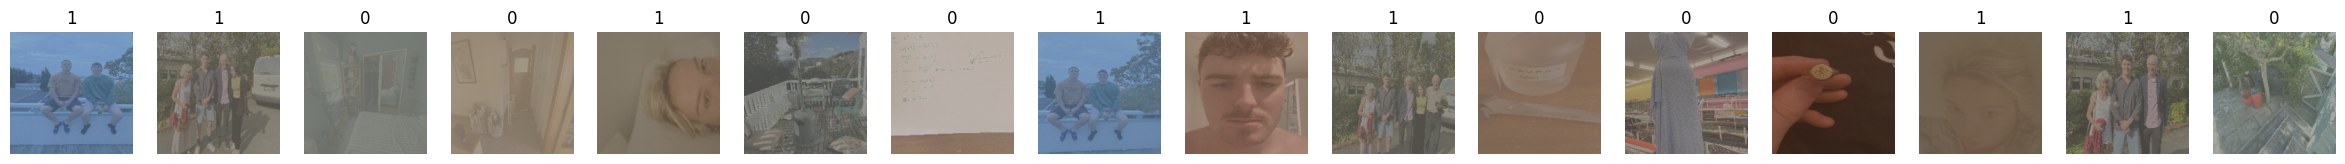

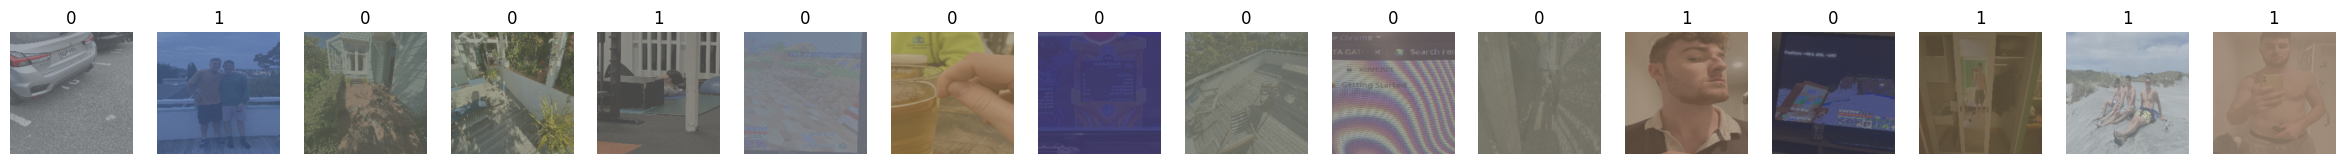

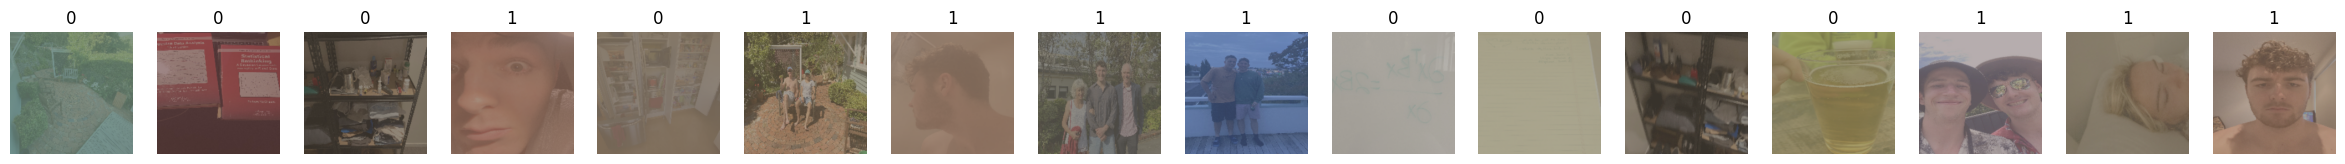

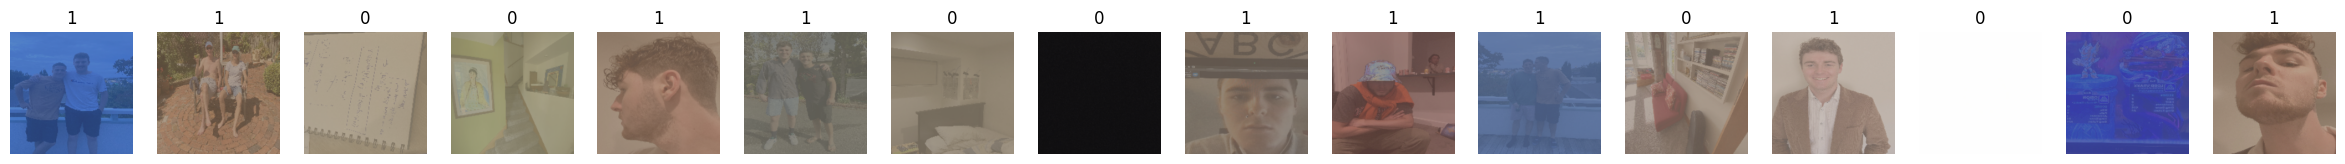

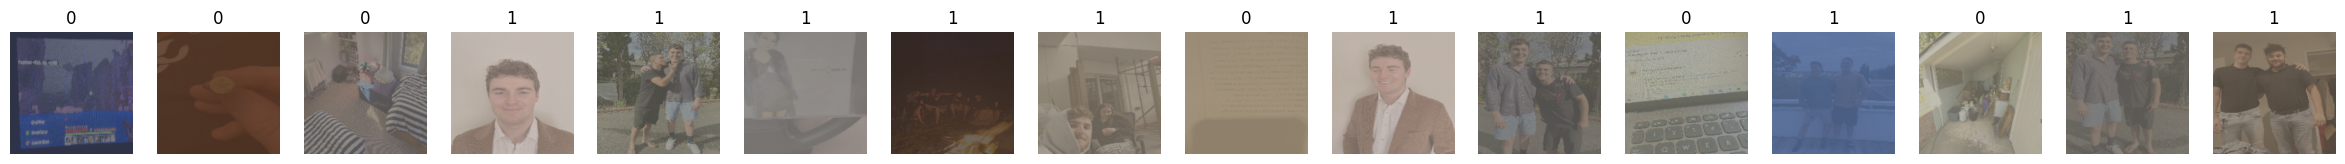

In [299]:
# Define a function to display images using Matplotlib
def display_images(images_batch, labels_batch):
    fig, axes = plt.subplots(1, len(images_batch), figsize=(30, 30))
    for i, (image, label) in enumerate(zip(images_batch, labels_batch)):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(str(label.numpy()))
    plt.show()

# Assuming you are iterating over the dataset batches
for i, batch in enumerate(train_ds):
    # Get the images and labels from the batch
    images_batch, labels_batch = batch

    # Convert the images to numpy arrays (optional)
    images_batch = images_batch.numpy()
    
    # Display the images in the batch using Matplotlib
    display_images(images_batch, labels_batch)
    if i > 3:
        break

<br>

# 3. Training

untrained accuracy

In [316]:
finetune_model = get_model()

In [317]:
from sklearn.metrics import accuracy_score 
import numpy as np

def model_eval():
    preds_ypred = []
    preds_ytrue = []
    for batch_index, (img, label) in enumerate(test_dataset):
        pred = finetune_model(img)
        if pred.numpy() > 0 :
            preds_ypred.append(1)
        else: 
            preds_ypred.append(0)
        preds_ytrue.append(label.numpy())
    return preds_ytrue, preds_ypred

ytrue, ypred = model_eval()
accuracy_score(ytrue, ypred)

0.42857142857142855

In [318]:
#finetune_model = get_model()
opt = tf.keras.optimizers.AdamW(learning_rate=3e-4)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.Accuracy()]
finetune_model.compile(optimizer=opt, loss=bce, metrics=metrics)
history = finetune_model.fit(train_dataset, epochs=5, steps_per_epoch=5)

Epoch 1/5
5/5 [==============================] - 5s 34ms/step - loss: 0.7139 - accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 0s 34ms/step - loss: 0.6557 - accuracy: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 0s 33ms/step - loss: 0.6074 - accuracy: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 0s 33ms/step - loss: 0.5147 - accuracy: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 0s 33ms/step - loss: 0.4940 - accuracy: 0.0000e+00


In [319]:
history.history

{'loss': [0.7139378190040588,
  0.655694842338562,
  0.6074286699295044,
  0.514665424823761,
  0.4940471053123474],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}

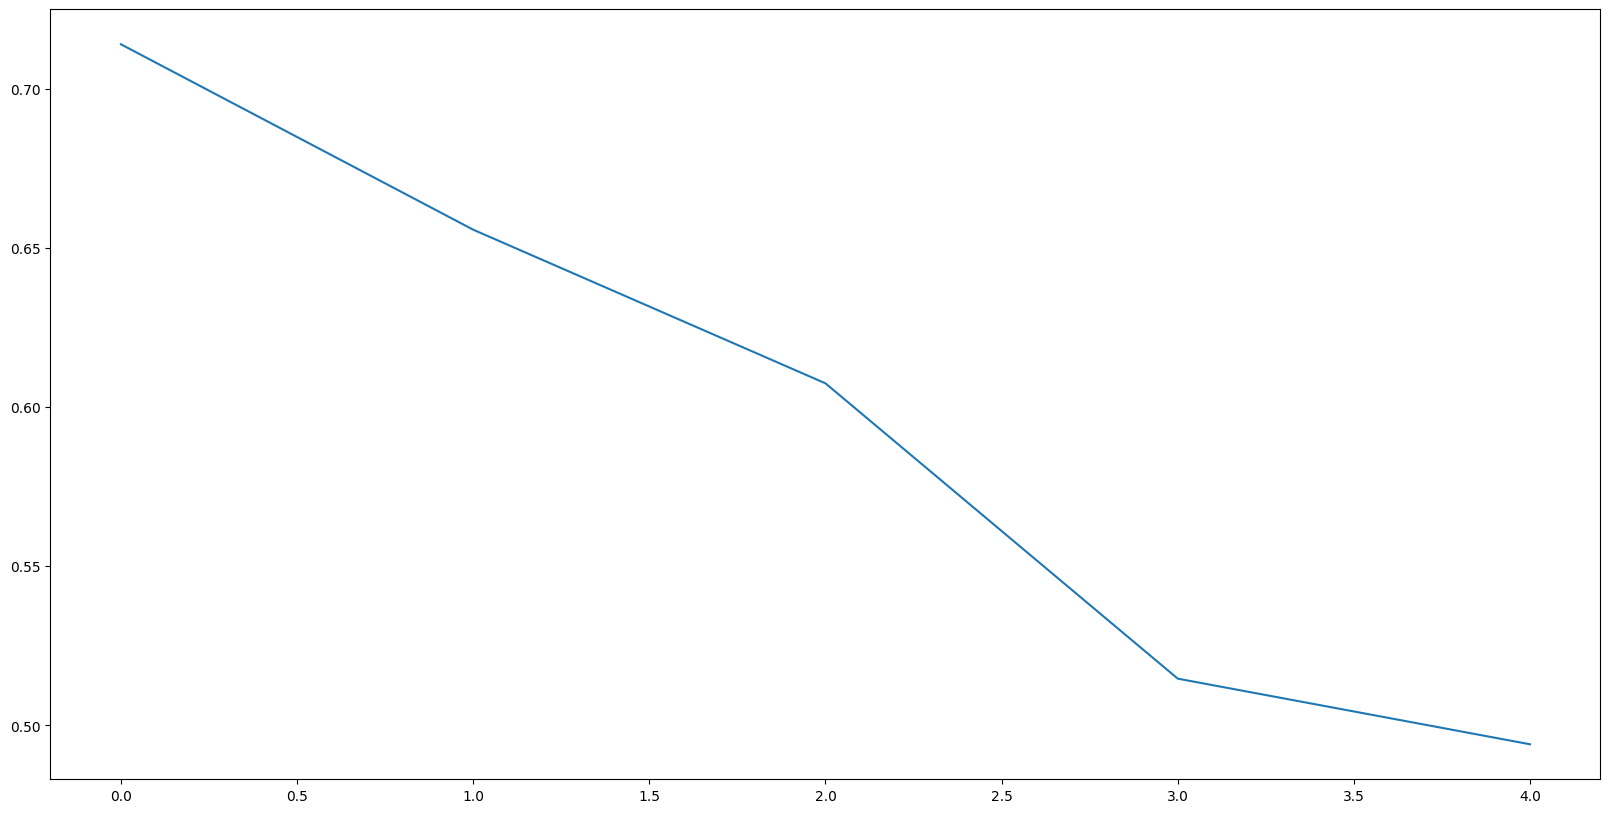

In [320]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.plot(np.arange(len(history.history['loss'])), history.history['loss'])

loss doesn't change, but have no data. 

evaluate on test set:

In [321]:
ytrue, ypred = model_eval()
accuracy_score(ytrue, ypred)

0.8947368421052632